In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import moca, dopioe, espra, plot_ellipse, gaussian_vel_reconstruction, smooth


### Error Tests

In [2]:
def gen_eddy(xc=0.0, yc=0.0, q11=.2, q12=.0, q22=.2, Rc=40.0, psi0=100.0):

    width=500
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # psi0 = 100
    # Rc = 40
    # xc, yc = 0, 0 
    # q11, q12, q22 = .2, 0.0, .2
    
    dx, dy = X-xc, Y-yc
    rho      = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
    rho_x    = 2*q11*dx   + 2*q12*dy
    rho_y    = 2*q12*dx   + 2*q22*dy
    exp_t    = np.exp(-rho/Rc**2)
    u   =  psi0/Rc**2 * rho_y * exp_t
    v   = -psi0/Rc**2 * rho_x * exp_t

    s = -psi0/Rc**2

    q = np.array([[q11, q12], [q12, q22]])
    Q = s*q
    w = 2*(Q[0,0] + Q[1,1])

    return u, v, x, y, xc, yc, w, Q, Rc, psi0, q


,Rc,psi0,q
0,10,50,"[[0.02, 0.0], [0.0, 0.02]]"
1,10,100,"[[0.02, 0.0], [0.0, 0.02]]"
2,10,200,"[[0.02, 0.0], [0.0, 0.02]]"
3,40,50,"[[0.02, 0.0], [0.0, 0.02]]"
4,40,100,"[[0.02, 0.0], [0.0, 0.02]]"
5,40,200,"[[0.02, 0.0], [0.0, 0.02]]"
6,80,50,"[[0.02, 0.0], [0.0, 0.02]]"
7,80,100,"[[0.02, 0.0], [0.0, 0.02]]"
8,80,200,"[[0.02, 0.0], [0.0, 0.02]]"


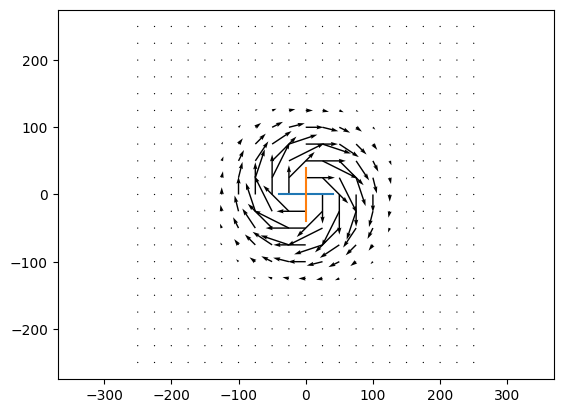

In [3]:
df_tests = pd.DataFrame(columns=['Rc', 'psi0', 'q'])

q1 = np.array([[.002, .0], [.0, .002]])
q2 = np.array([[.02, .0], [.0, .02]])
q3 = np.array([[.02, .01], [.01, .02]])

Rc1, Rc2, Rc3 = 10, 40, 80

psi01, psi02, psi03 = 50, 100, 200

from itertools import product

# q_list = [q1, q2, q3]
q_list = [q2]
Rc_list = [Rc1, Rc2, Rc3]
psi0_list = [psi01, psi02, psi03]

df_tests = pd.DataFrame(
    [(Rc, psi0, q) for Rc, psi0, q in product(Rc_list, psi0_list, q_list)],
    columns=['Rc', 'psi0', 'q']
)

data = df_tests.iloc[2]
u, v, x, y, xc, yc, w, Q, Rc, psi0, q = gen_eddy(0.0, 0.0, data.q[0,0], data.q[0,1], data.q[1,1], data.Rc, data.psi0)
X, Y = np.meshgrid(x, y, indexing='ij')
spac = 5
plt.quiver(X[::spac, ::spac], Y[::spac, ::spac], u[::spac, ::spac], v[::spac, ::spac], scale=30)
plt.axis('equal')

nic, njc, r = 50, 50, 8

x1 = x[nic-r:nic+r+1]
y1 = np.array([y[njc]]*len(x1))

y2 = y[nic-r:nic+r+1]
x2 = np.array([x[nic]]*len(y2))

plt.plot(x1, y1)
plt.plot(x2, y2)

df_tests


In [4]:
# def rrmse_percentage(control, new):
#     control = np.asarray(control)
#     new = np.asarray(new)
#     rmse = np.sqrt(np.mean((new - control)**2))
#     return (rmse / np.mean(control)) * 100

def rro_percent(control, new):
    if control == 0:
        return 0.0 if new == 0 else np.inf
    return abs(new - control) / abs(control) * 100
    

In [5]:
dic_tests = {}

for test in range(len(df_tests)):
    df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q11', 'Q12', 'Q22', 'Rc', 'psi0', 'q11', 'q12', 'q22'])
    
    data = df_tests.iloc[test]
    u, v, x, y, xc, yc, w, Q, Rc, psi0, q = gen_eddy(0.0, 0.0,
                                                     data.q[0,0], data.q[0,1], data.q[1,1],
                                                     data.Rc, data.psi0)
    q11, q12, q22 = q[0,0], q[0,1], q[1,1]

    s = -psi0 / Rc**2
    df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': 2*s*(q11+q22),
                           'Q11': s * q11, 'Q12': s * q12, 'Q22': s * q22, 
                           'Rc': Rc, 'psi0': psi0, 'q11': q11, 'q12': q12, 'q22': q22}    

    nic, njc, r = 50, 50, 8

    # Transect Data
    x1 = x[nic-r:nic+r+1]
    y1 = np.array([y[njc]]*len(x1))
    u1, v1 = u[nic-r:nic+r+1, njc], v[nic-r:nic+r+1, njc]
    
    y2 = y[nic-r:nic+r+1]
    x2 = np.array([x[nic]]*len(y2))
    u2, v2 = u[nic, njc-r:njc+r+1], v[nic, njc-r:njc+r+1]
    
    # Scattered Data
    I, J = np.meshgrid(np.arange(X.shape[0]), np.arange(X.shape[1]))
    i_mask, j_mask = np.where(np.hypot(I-nic, J-njc) < r)
    xi, yi = X[i_mask, j_mask], Y[i_mask, j_mask]
    ui, vi = u[i_mask, j_mask], v[i_mask, j_mask]

    # MOCA
    xc_moc, yc_moc, w_moc, Q_moc, Rc_moc, psi0_moc, q_moc = moca(x1-x1[0], u1, v1)
    xc_moc += x1[0]  
    yc_moc += y1[0]  
    q11_moc, q12_moc, q22_moc = q_moc[0, 0], q_moc[0, 1], q_moc[1, 1]
    
    df_res.loc[len(df_res)] = {'xc': xc_moc, 'yc': yc_moc, 'w': w_moc,
                               'Q11': Q_moc[0, 0], 'Q12': Q_moc[0, 1], 'Q22': Q_moc[1, 1],
                               'Rc': Rc_moc, 'psi0': psi0_moc, 'q11': q11_moc, 'q12': q12_moc, 'q22': q22_moc}

    # df_res.loc[len(df_res)] = {'xc': rro_percent(xc, xc_moc), 'yc': rro_percent(yc, yc_moc), 'w': rro_percent(w, w_moc),
    #                            'Q11': rro_percent(Q[0,0], Q_moc[0, 0]), 'Q12': rro_percent(Q[0,1], Q_moc[0, 1]), 'Q22': rro_percent(Q[1,1], Q_moc[1, 1]),
    #                            'Rc': rro_percent(Rc, Rc_moc), 'psi0': rro_percent(psi0, psi0_moc),
    #                            'q11': rro_percent(q11, q11_moc), 'q12': rro_percent(q12, q12_moc), 'q22': rro_percent(q22, q22_moc)}

    
    # DOPIOE
    xc_dop, yc_dop, w_dop, Q_dop, Rc_dop, psi0_dop, q_dop = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
    q11_dop, q12_dop, q22_dop = q_dop[0, 0], q_dop[0, 1], q_dop[1, 1]
    
    df_res.loc[len(df_res)] = {'xc': xc_dop, 'yc': yc_dop, 'w': w_dop,
                               'Q11': Q_dop[0, 0], 'Q12': Q_dop[0, 1], 'Q22': Q_dop[1, 1],
                               'Rc': Rc_dop, 'psi0': psi0_dop, 'q11': q11_dop, 'q12': q12_dop, 'q22': q22_dop}

    
    # df_res.loc[len(df_res)] = {'xc': rro_percent(xc, xc_dop), 'yc': rro_percent(yc, yc_dop), 'w': rro_percent(w, w_dop),
    #                            'Q11': rro_percent(Q[0,0], Q_dop[0, 0]), 'Q12': rro_percent(Q[1,0], Q_dop[0, 1]), 'Q22': rro_percent(Q[1,1], Q_dop[1, 1]),
    #                            'Rc': rro_percent(Rc, Rc_dop), 'psi0': rro_percent(psi0, psi0_dop),
    #                            'q11': rro_percent(q11, q11_dop), 'q12': rro_percent(q12, q12_dop), 'q22': rro_percent(q22, q22_dop)}
    
    # ESPRA
    xc_esp, yc_esp, w_esp, Q_esp, Rc_esp, psi0_esp, q_esp = espra(xi, yi, ui, vi)
    q11_esp, q12_esp, q22_esp = q_esp[0, 0], q_esp[0, 1], q_esp[1, 1]

    df_res.loc[len(df_res)] = {'xc': xc_esp, 'yc': yc_esp, 'w': w_esp,
                           'Q11': Q_esp[0, 0], 'Q12': Q_esp[0, 1], 'Q22': Q_esp[1, 1],
                           'Rc': Rc_esp, 'psi0': psi0_esp, 'q11': q11_esp, 'q12': q12_esp, 'q22': q22_esp}

    
    # df_res.loc[len(df_res)] = {'xc': rro_percent(xc, xc_esp), 'yc': rro_percent(yc, yc_esp), 'w': rro_percent(w, w_esp),
    #                            'Q11': rro_percent(Q[0,0], Q_esp[0, 0]), 'Q12': rro_percent(Q[1,0], Q_esp[0, 1]), 'Q22': rro_percent(Q[1,1], Q_esp[1, 1]),
    #                            'Rc': rro_percent(Rc, Rc_esp), 'psi0': rro_percent(psi0, psi0_esp),
    #                            'q11': rro_percent(q11, q11_esp), 'q12': rro_percent(q12, q12_esp), 'q22': rro_percent(q22, q22_esp)}

    
    # df_res.index = ['Control', 'MOCA', 'MOCA_ERR', 'DOPIOE', 'DOPIOE_ERR', 'ESPRA', 'ESPRA_ERR']
    df_res.index = ['Control', 'MOCA', 'DOPIOE', 'ESPRA']

    dic_tests[f'T{test}'] = df_res
        

In [12]:
dic_tests['T1']

,xc,yc,w,Q11,Q12,Q22,Rc,psi0,q11,q12,q22
Control,0.000000e+00,0.000000e+00,-0.080000,-0.020000,-0.000000e+00,-0.020000,10.000000,100.000000,0.020000,0.000000e+00,0.020000
MOCA,0.000000e+00,0.000000e+00,-0.078982,-0.019746,0.000000e+00,-0.019746,72.470989,104.202834,0.995220,-0.000000e+00,0.995220
DOPIOE,0.000000e+00,0.000000e+00,-0.078982,-0.019746,0.000000e+00,-0.019746,72.470989,104.202834,0.995220,-0.000000e+00,0.995220
ESPRA,-4.635284e-17,-5.934447e-17,-0.065359,-0.016340,3.117762e-18,-0.016340,204.911089,719.478033,0.953587,-1.819518e-16,0.953587


In [7]:
df_tests

,Rc,psi0,q
0,10,50,"[[0.02, 0.0], [0.0, 0.02]]"
1,10,100,"[[0.02, 0.0], [0.0, 0.02]]"
2,10,200,"[[0.02, 0.0], [0.0, 0.02]]"
3,40,50,"[[0.02, 0.0], [0.0, 0.02]]"
4,40,100,"[[0.02, 0.0], [0.0, 0.02]]"
5,40,200,"[[0.02, 0.0], [0.0, 0.02]]"
6,80,50,"[[0.02, 0.0], [0.0, 0.02]]"
7,80,100,"[[0.02, 0.0], [0.0, 0.02]]"
8,80,200,"[[0.02, 0.0], [0.0, 0.02]]"


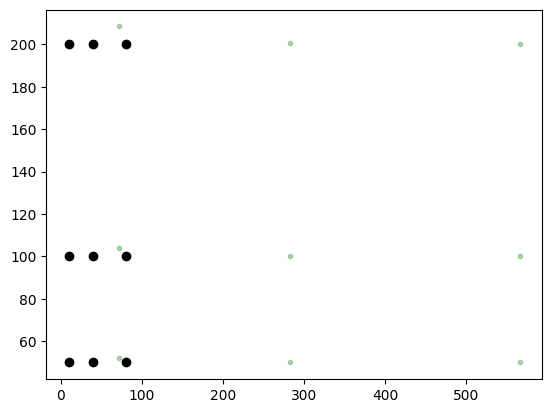

In [8]:
plt.scatter(df_tests.Rc, df_tests.psi0, color='k')
for test in dic_tests.keys():
    df = dic_tests[test]
    # plt.scatter(df.iloc[0].Rc, df.iloc[0].psi0, color='r', marker='.', alpha=.3)
    plt.scatter(df.iloc[1].Rc, df.iloc[1].psi0, color='g', marker='.', alpha=.3)
    # plt.scatter(df.iloc[2].Rc, df.iloc[2].psi0, color='b', marker='.', alpha=.3)
    